QUESTION 1 A

ENTER THE TIME STEP: 0.1
TIME REQUIRED IS:  597.7000000000673


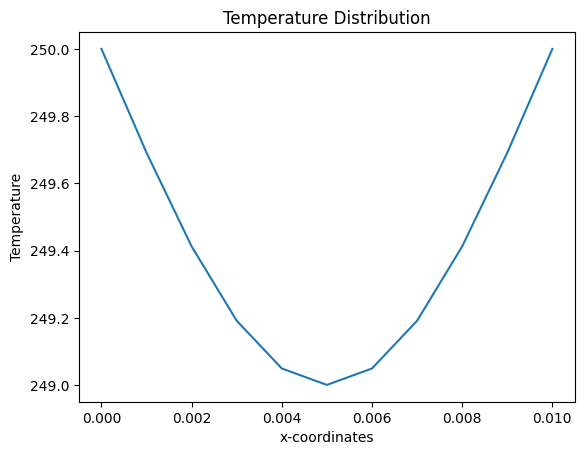

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
#print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30

while (T_new[5] <= 249.00):
  t = t + dt
  for i in range(1,(len(T_old)-1)):
    T_new[i] = C*T_old[i-1] + (1-2*C)*T_old[i] + C*T_old[i+1]
  T_new = applybc(T_new)
  if (T_new[5] > 249.00):
    break
  #print(T_new)
  for i in range(0,len(T_new)):
    T_old[i] = T_new[i]
plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
print("TIME REQUIRED IS: ",t)

QUESTION 1 B WITHOUT DMD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Now we will start defining the TDMA function
def tdma(num, dia, upp, low, uPrev, u):
    P    = np.zeros(num)
    Q    = np.zeros(num)

    # Forward elimination
    P[0] = -upp[0]/dia[0]
    Q[0] =  uPrev[0]/dia[0]
    for i in range(1, len(dia)):
        P[i] = -(upp[i]/(dia[i]+low[i]*P[i-1]))
        Q[i] =  (uPrev[i] - low[i]*Q[i-1])/(dia[i]+low[i]*P[i-1])

    # Backward Substitution
    u[-1] = Q[-1]
    for i in range(len(dia)-2,-1,-1):
        u[i] = P[i]*u[i+1]+Q[i]
    return u


k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.0001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
#print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))


# Diagonal elements of system matrix
d    = np.zeros(len(X))        # main diagonal elements
u    = np.zeros(len(X))        # upper diagonal
l    = np.zeros(len(X))        # lower diagonal
RHS  = np.zeros(len(X))

u[0]   = 0
d[0]   = 1
l[0]   = 0
RHS[0] = 250
u[-1]  = 0
d[-1]  = 1
l[-1]  = 0
RHS[-1]= 250

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30

# Solve the discretized equation until steady state is achieved
norm_collect = []         # To collect the norm
sub_list = list([])       # Making a list to store the difference between the two arrays
norm        = 100.0       # Measure of residual or error
iter        = 0           # Iteration counter
converged   = False       # Convergence flag - changes to "True" upon convergence


while (converged==False):
  t = t + dt

  for i in range(1,len(T_new)-1):
    l[i]  = -C/2
    u[i]  = -C/2
    d[i]  = (1+C)
    RHS[i]= (C/2)*T_old[i-1] + (1-C)*T_old[i] + (C/2)*T_old[i+1]

  T_new = tdma(len(X), d, u, l, RHS, T_new)
  sub_list = list([])

  # Increment iteration counter
  iter = iter + 1

  for i1,i2 in zip(T_new,T_old):
    sub_list.append(abs(i1-i2))

  norm = max(sub_list)/dt

  norm_collect.append(norm)

  if norm <10**-6:
    converged = True

  #print(T_new)
  for i in range(0,len(T_new)):
    T_old[i] = T_new[i]

  print(norm)

plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
plt.show()
print(T_new)
tsteps = np.linspace(1,iter,iter)
norm_collect = np.array(norm_collect)
plt.plot(tsteps,norm_collect)
plt.yscale('log')
plt.xlabel("time steps")
plt.ylabel("norm")
plt.show()




ENTER THE TIME STEP: 0.01
22000.0
1770.7673932722842
1478.8843285250578
1246.630018788842
1060.4198118003737
909.9767467806159
787.489142363637
686.9898132790055
603.8971570720676
534.6747785047995
476.5781598286452
427.4654365344247
385.655526554865
354.99115256311455
339.49558753494244
324.371969501658
309.7776497215719
295.80669696066195
282.5088634266649
269.90322364111137
257.9879605558389
246.7473647925857
236.15681833407223
226.18632131072332
216.80296677255484
207.9726570548047
199.6612747173657
191.8354625599008
184.46312476196027
177.51373035448665
170.95847780647375
164.7703632015947
158.92418261515218
153.39649067064016
148.5881743285077
145.312145372246
142.11222959033876
138.99065021896604
135.9487133947212
132.98697968711366
130.10540679911742
127.30346816628071
124.58025142105811
121.93454004360831
119.36488097715028
116.86964052994426
114.44705050389103
112.09524617010089
109.81229744464827
107.5962343946955
105.44506801891487
103.35680709080748
101.3294717238125
99.36

KeyboardInterrupt: ignored

QUESTION 1 B WITH DMD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Now we will integrate the Dynamic Mode Decomposition
#Now we will define a function named DMDsolver which will split up our given matrix X into two matrices X1 and X2
def DMDsolver(X_given,r,no_predictions,dt):
  X1 = X_given[:, : -1] #splitting our given matrix into two matrices X1 and X2
  X2 = X_given[:, 1 :]
  #R, C = X.shape #R,C rows and columns no , shape function performs the task of finding no of rows and columns
  U, E, Vt = np.linalg.svd(X1, full_matrices = False) #Applying SVD on X1 as a first step of DMD algorithm
  """In the next step we obtain the matrix A_bar which is an second and important step in DMD algo, this matrix is obtained by multiplication
  of the truncated  matrices"""
  A_bar = np.matmul((np.matmul(np.matmul(U[:, : r].conj().T,X2),Vt[: r, :].conj().T)),np.diag(np.reciprocal(E[: r])))
  '''In the following step we obtain the eigen decomposition of the matrix A_bar into two matrices Phi and Q representing eigen values
  and eigen vectors matrices respectively'''
  Phi, Q = np.linalg.eig(A_bar)
  '''The following step we find Psi matrix in order to find A matrix '''
  Psi=np.matmul(np.matmul(np.matmul(X2,Vt[: r, :].conj().T),np.diag(np.reciprocal(E[: r]))),Q) #dmd mode
  #Here we go to the final step of finding our matrix A which is the root of DMD prediction
  A=np.matmul(np.matmul(Psi,np.diag(Phi)),np.linalg.pinv(Psi)) #not needed from this line for finite differences
  x2 = X2[:,-1]
  #print(Psi)
  bi = (np.matmul(np.linalg.pinv(Psi),x2))
  dd1 = ((bi[0])*(Psi[:,0])).real
  dd2 = ((bi[1])*(Psi[:,1])).real
  dd3 = ((bi[2])*(Psi[:,2])).real
  dd4 = ((bi[3])*(Psi[:,3])).real
  dd5 = np.zeros(len(dd1))
  for i in range(len(dd1)):
   dd5[i] = dd1[i] + dd2[i] + dd3[i] +dd4[i]
  print("Eigen values are",Phi)
  return dd1 #returning predicted values matrix



#Now we will start defining the TDMA function
def tdma(num, dia, upp, low, uPrev, u):
    P    = np.zeros(num)
    Q    = np.zeros(num)

    # Forward elimination
    P[0] = -upp[0]/dia[0]
    Q[0] =  uPrev[0]/dia[0]
    for i in range(1, len(dia)):
        P[i] = -(upp[i]/(dia[i]+low[i]*P[i-1]))
        Q[i] =  (uPrev[i] - low[i]*Q[i-1])/(dia[i]+low[i]*P[i-1])

    # Backward Substitution
    u[-1] = Q[-1]
    for i in range(len(dia)-2,-1,-1):
        u[i] = P[i]*u[i+1]+Q[i]
    return u


k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.0001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
#print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))


# Diagonal elements of system matrix
d    = np.zeros(len(X))        # main diagonal elements
u    = np.zeros(len(X))        # upper diagonal
l    = np.zeros(len(X))        # lower diagonal
RHS  = np.zeros(len(X))

u[0]   = 0
d[0]   = 1
l[0]   = 0
RHS[0] = 250
u[-1]  = 0
d[-1]  = 1
l[-1]  = 0
RHS[-1]= 250

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30

# Solve the discretized equation until steady state is achieved
norm_collect = []         # To collect the norm
sub_list = list([])       # Making a list to store the difference between the two arrays
norm        = 100.0       # Measure of residual or error
iter        = 0           # Iteration counter
converged   = False       # Convergence flag - changes to "True" upon convergence
Y=list([])
lo = 1
PPP=0

while (converged==False):

  if ((norm>0.1) and (PPP<=1)):
    t = t + dt

    for i in range(1,len(T_new)-1):
      l[i]  = -C/2
      u[i]  = -C/2
      d[i]  = (1+C)
      RHS[i]= (C/2)*T_old[i-1] + (1-C)*T_old[i] + (C/2)*T_old[i+1]

    T_new = tdma(len(X), d, u, l, RHS, T_new)
    sub_list = list([])

    # Increment iteration counter
    iter = iter + 1

    for i1,i2 in zip(T_new,T_old):
      sub_list.append(abs(i1-i2))

    norm = max(sub_list)/dt

    norm_collect.append(norm)

    if norm <10**-6:
      converged = True

    #print(T_new)
    for i in range(0,len(T_new)):
      T_old[i] = T_new[i]


    nu = iter
    ic = iter

  else:
    #print(u_old,903480935874)
    PPP = 5
    if (norm<=10**-6):
      converged = True
    if ((iter==nu) and (lo<=20) and (iter==ic)):
      Y.append(T_old)
      nu=nu+20
      ic=ic+20
      if (lo==20):
        #print(1111111111123456789999999999999998765)
        Y = np.array(Y)
        Y = Y.transpose()
        T_old = DMDsolver(Y,5,1,dt)
        ic = ic + 200
        nu = iter
        Y=list([])
        #print(nu,ic,iter)
        lo = 0
      lo=lo+1
    t = t + dt

    for i in range(1,len(T_new)-1):
      l[i]  = -C/2
      u[i]  = -C/2
      d[i]  = (1+C)
      RHS[i]= (C/2)*T_old[i-1] + (1-C)*T_old[i] + (C/2)*T_old[i+1]

    T_new = tdma(len(X), d, u, l, RHS, T_new)
    sub_list = list([])

    # Increment iteration counter
    iter = iter + 1

    for i1,i2 in zip(T_new,T_old):
      sub_list.append(abs(i1-i2))

    norm = max(sub_list)/dt

    norm_collect.append(norm)

    if norm <10**-6:
      converged = True

    #print(T_new)
    for i in range(0,len(T_new)):
      T_old[i] = T_new[i]


    if (iter == ic):
      nu =iter




plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
plt.show()
print(T_new)
tsteps = np.linspace(1,iter,iter)
norm_collect = np.array(norm_collect)
plt.plot(tsteps,norm_collect)
plt.yscale('log')
plt.xlabel("time steps")
plt.ylabel("norm")
plt.show()




ENTER THE TIME STEP: 0.01
Eigen values are [ 1.00000000e+00 -2.68286857e+46 -1.98070406e+28 -4.59874706e+27
 -6.90997262e+20]
Eigen values are [ 3.55969254e-02  1.45237960e+01  1.61025116e+13  1.12657050e-12
 -2.58253394e-13]
Eigen values are [ 1.00000000e+00 -7.84405456e+45 -7.92281625e+28 -5.09328906e+28
 -6.57064081e+19]
Eigen values are [ 3.55969254e-02  1.45237960e+01  1.61025116e+13  1.12657050e-12
 -2.58253394e-13]
Eigen values are [ 1.00000000e+00 -7.84405456e+45 -7.92281625e+28 -5.09328906e+28
 -6.57064081e+19]
Eigen values are [ 3.55969254e-02  1.45237960e+01  1.61025116e+13  1.12657050e-12
 -2.58253394e-13]
Eigen values are [ 1.00000000e+00 -7.84405456e+45 -7.92281625e+28 -5.09328906e+28
 -6.57064081e+19]
Eigen values are [ 3.55969254e-02  1.45237960e+01  1.61025116e+13  1.12657050e-12
 -2.58253394e-13]
Eigen values are [ 1.00000000e+00 -7.84405456e+45 -7.92281625e+28 -5.09328906e+28
 -6.57064081e+19]
Eigen values are [ 3.55969254e-02  1.45237960e+01  1.61025116e+13  1.12657

KeyboardInterrupt: ignored

QUESTION 1 C

ENTER THE TIME STEP: 5.3
[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009 0.01 ]
TIME REQUIRED IS:  105.99999999999997


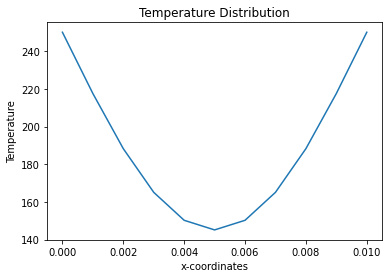

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Now we will start defining the TDMA function
def tdma(num, dia, upp, low, uPrev, u):
    P    = np.zeros(num)
    Q    = np.zeros(num)

    # Forward elimination
    P[0] = -upp[0]/dia[0]
    Q[0] =  uPrev[0]/dia[0]
    for i in range(1, len(dia)):
        P[i] = -(upp[i]/(dia[i]+low[i]*P[i-1]))
        Q[i] =  (uPrev[i] - low[i]*Q[i-1])/(dia[i]+low[i]*P[i-1])

    # Backward Substitution
    u[-1] = Q[-1]
    for i in range(len(dia)-2,-1,-1):
        u[i] = P[i]*u[i+1]+Q[i]
    return u


k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))


# Diagonal elements of system matrix
d    = np.zeros(len(X))        # main diagonal elements
u    = np.zeros(len(X))        # upper diagonal
l    = np.zeros(len(X))        # lower diagonal
RHS  = np.zeros(len(X))

u[0]   = 0
d[0]   = 1
l[0]   = 0
RHS[0] = 250
u[-1]  = 0
d[-1]  = 1
l[-1]  = 0
RHS[-1]= 250

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30

while (T_new[5] <= 140.00):
  t = t + dt

  for i in range(1,len(T_new)-1):
    l[i]  = -C
    u[i]  = -C
    d[i]  = (1+2*C)
    RHS[i]= T_old[i]

  T_new = tdma(len(X), d, u, l, RHS, T_new)

  if (T_new[5] > 140.00):
    break

  #print(T_new)
  for i in range(0,len(T_new)):
    T_old[i] = T_new[i]
plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
print("TIME REQUIRED IS: ",t)

QUESTION 2 A

ANALYTICAL SOLUTION

Enter the no of nodes in x: 128
Enter the no of nodes in y: 256


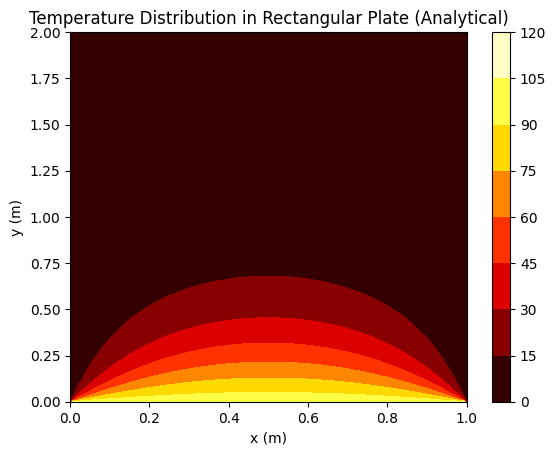

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt

lx = 1
ly = 2

H = 2
L = 1
no_mesh_x = int(input("Enter the no of nodes in x: "))
no_mesh_y = int(input("Enter the no of nodes in y: "))
dx = lx / (no_mesh_x - 1)
dy = ly / (no_mesh_y - 1)
Pos = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
#print(Pos)
T1= 100
x=0
y=0

for i in range(no_mesh_y):
  y=i*dy
  for j in range(no_mesh_x):
    x=j*dx
    Pos[i][j]=(x,y)
  x=0

def T_ana_trunc(position):
  T=0
  mag=0
  n=1
  while (n<101):
    T = T + (2*T1)*((1-(-1)**n)*mt.sinh((n*mt.pi*(H-position[1]))/L)*mt.sin(n*mt.pi*position[0]/L))/(mt.sinh(n*mt.pi*H/L)*n*mt.pi)
    #mag = (2*T1)*((1-(-1**n))*mt.sinh((n*mt.pi*(H-position[1]))/L)*mt.sin(n*mt.pi*position[0]/L))/(mt.sinh(n*mt.pi*H/L)*n*mt.pi)
    n = n + 1

  #print(T)
  return T

x = np.array(np.linspace(0, L,no_mesh_x ))
y = np.array(np.linspace(0, H,no_mesh_y))

Tx = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    Tx[i][j]= T_ana_trunc(Pos[i][j])

Tx = np.array(Tx)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Tx, cmap='hot')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution in Rectangular Plate (Analytical)')
plt.show()

GAUSS SIEDEL (POINT BY POINT) (W/O DMD)

Streaming output truncated to the last 5000 lines.
6.76256465315106e-06
6.7599745499080655e-06
6.757385440536723e-06
6.754797326813389e-06
6.752210204297171e-06
6.7496240747644265e-06
6.747038938215155e-06
6.744454792873e-06
6.741871638737962e-06
6.73928947581004e-06
6.736708304977412e-06
6.734128122687366e-06
6.731548931604436e-06
6.728970729064088e-06
6.726393516842677e-06
6.723817292275669e-06
6.721242058027599e-06
6.718667809657575e-06
6.716094548941953e-06
6.713522277657091e-06
6.710950991362097e-06
6.7083806936096835e-06
6.705811379070781e-06
6.703243053074459e-06
6.700675712068005e-06
6.698109354275061e-06
6.695543983248342e-06
6.6929795954351334e-06
6.690416192611792e-06
6.687853771225605e-06
6.685292333941106e-06
6.682731880758297e-06
6.6801724072362845e-06
6.677613917815961e-06
6.675056408944613e-06
6.672499884174954e-06
6.6699443364015565e-06
6.667389770953491e-06
6.664836185166223e-06
6.66228357992793e-06
6.659731952574077e-06
6.657181304881021e-06
6.654631635960584e-06
6.6

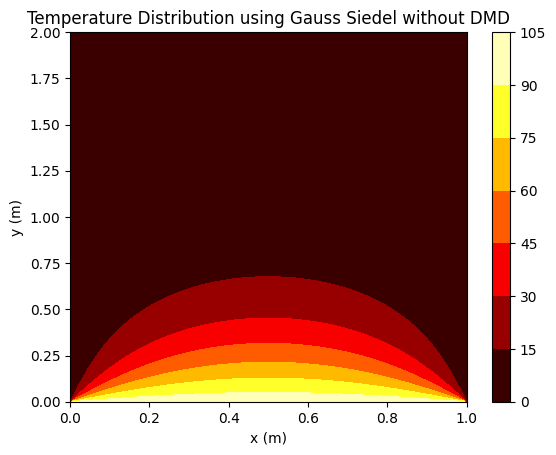

error with analytical is (w/o dmd):  0.0008479267896093375
Time required for excecution (w/o dmd):  3298.0694572925568
Iterations (w/o dmd):  22787


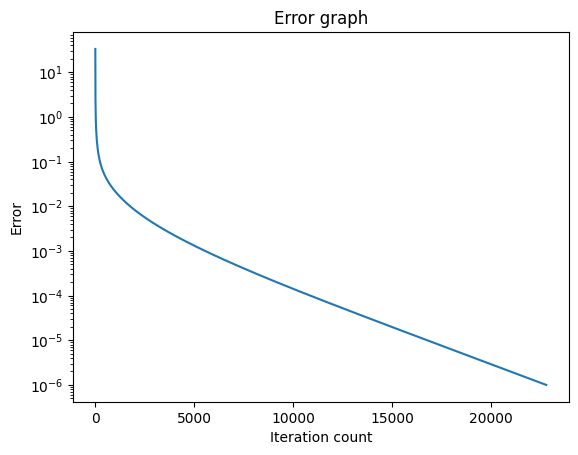

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import time

#Now we will start initializing the conditions
lx = 1
ly = 2

tol     = 10**-6         # tolerance to stop  iterations
H = 2
L = 1
no_mesh_x = int(input("Enter the no of nodes in x: "))
no_mesh_y = int(input("Enter the no of nodes in y: "))
dx = lx / (no_mesh_x - 1)
dy = ly / (no_mesh_y - 1)
Pos = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
#print(Pos)
T1= 100
x=0
y=0
for i in range(no_mesh_y):
  y=i*dy
  for j in range(no_mesh_x):
    x=j*dx
    Pos[i][j]=(x,y)
  x=0
T_old =np.zeros((no_mesh_y,no_mesh_x))
T_new = np.zeros((no_mesh_y,no_mesh_x))
T_guess = np.zeros((no_mesh_y,no_mesh_x))
T_guess[0:-1,0:-1] = 0  #Change here the inital guess value
error=[]
for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

err = np.zeros((no_mesh_y,no_mesh_x))

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_old[i][j]= T_guess[i][j]

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_new[i][j]= T_guess[i][j]
#print(T_new)

converged = False

start_time = time.time()

while (converged<=False):
  for i in range(1,no_mesh_y-1):
    for j in range(1,no_mesh_x-1):
      T_new[i][j]= (T_new[i+1][j] + T_new[i-1][j] + T_new[i][j+1] + T_new[i][j-1])/4
  #print(T_new)
  for i in range(0,no_mesh_y):
    for j in range(0,no_mesh_x):
      err[i][j]= abs(T_new[i][j] - T_old[i][j])
  #print(err)
  error.append(np.max(err))
  if (np.max(err) < tol): #setting up the convergence criterion
    converged = True
  print(np.max(err))
  for i in range(no_mesh_y):
    for j in range(no_mesh_x):
      T_old[i][j]= T_new[i][j]

end_time = time.time()
execution_time = end_time - start_time
#print(T_new)
iter = np.array(np.arange(1,len(error)+1,1))
iter=np.array(iter)
error=np.array(error)
T_new = np.array(T_new)
x = np.array(np.linspace(0, L,no_mesh_x ))
y = np.array(np.linspace(0, H,no_mesh_y))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, T_new, cmap='hot')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution using Gauss Siedel without DMD')
plt.show()
plt.plot(iter,error)
error_wodmd = error
iterwodmd = iter
plt.xlabel('Iteration count')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error graph')

#ERROR WITH ANALYTICAL
errana = np.zeros((no_mesh_y,no_mesh_x))
for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    errana[i][j] = abs(Tx[i][j]- T_new[i][j])

rmse = 0

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    rmse = rmse + ((errana[i][j])**2)

rmse = mt.sqrt(rmse)
rmse = rmse / (no_mesh_y*no_mesh_x)
print("error with analytical is (w/o dmd): ",rmse)
print("Time required for excecution (w/o dmd): ",execution_time)
print("Iterations (w/o dmd): ",iterwodmd[-1])

APPLYING DYNAMIC MODE DECOMPOSITION TO ABOVE QUESTION

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import time

def transpose(matrix):
    # Calculate the transpose of the matrix
    rows, cols = len(matrix), len(matrix[0])
    return [[matrix[j][i] for j in range(rows)] for i in range(cols)]

def matrix_multiply(matrix1, matrix2):
    # Calculate the matrix multiplication of two matrices
    rows1, cols1 = len(matrix1), len(matrix1[0])
    rows2, cols2 = len(matrix2), len(matrix2[0])

    result = [[0 for _ in range(cols2)] for _ in range(rows1)]

    for i in range(rows1):
        for j in range(cols2):
            for k in range(cols1):
                result[i][j] += matrix1[i][k] * matrix2[k][j]

    return result

def inverse(matrix):
    # Calculate the inverse of a 2x2 matrix
    a, b, c, d = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    determinant = a * d - b * c

    if determinant == 0:
        raise ValueError("Matrix is not invertible.")

    return [[d / determinant, -b / determinant], [-c / determinant, a / determinant]]

def pseudo_inverse(matrix):
    rows, cols = len(matrix), len(matrix[0])

    if rows >= cols:
        # Calculate the pseudo-inverse directly
        ATA = matrix_multiply(transpose(matrix), matrix)
        ATA_inv = inverse(ATA)
        A_pseudo_inv = matrix_multiply(ATA_inv, transpose(matrix))
    else:
        # Calculate the pseudo-inverse of the transpose
        AT = transpose(matrix)
        ATA = matrix_multiply(AT, matrix)
        ATA_inv = inverse(ATA)
        A_pseudo_inv = matrix_multiply(AT, ATA_inv)

    return A_pseudo_inv



#Now we will define a function named DMDsolver which will split up our given matrix X into two matrices X1 and X2
def DMDsolver(X_given,r,no_predictions,dt):
  X1 = X_given[:, : -1] #splitting our given matrix into two matrices X1 and X2
  X2 = X_given[:, 1 :]
  #R, C = X.shape #R,C rows and columns no , shape function performs the task of finding no of rows and columns
  U, E, Vt = np.linalg.svd(X1, full_matrices = False) #Applying SVD on X1 as a first step of DMD algorithm
  """In the next step we obtain the matrix A_bar which is an second and important step in DMD algo, this matrix is obtained by multiplication
  of the truncated  matrices"""
  A_bar = np.matmul((np.matmul(np.matmul(U[:, : r].conj().T,X2),Vt[: r, :].conj().T)),np.diag(np.reciprocal(E[: r])))
  '''In the following step we obtain the eigen decomposition of the matrix A_bar into two matrices Phi and Q representing eigen values
  and eigen vectors matrices respectively'''
  Phi, Q = np.linalg.eig(A_bar)
  '''The following step we find Psi matrix in order to find A matrix '''
  Psi=np.matmul(np.matmul(np.matmul(X2,Vt[: r, :].conj().T),np.diag(np.reciprocal(E[: r]))),Q) #dmd mode
  #Here we go to the final step of finding our matrix A which is the root of DMD prediction
  A=np.matmul(np.matmul(Psi,np.diag(Phi)),np.linalg.pinv(Psi)) #not needed from this line for finite differences
  x2 = X2[:,-1]
  #print(Psi)
  bi = (np.matmul(pseudo_inverse(Psi),x2))
  dd1 = ((bi[0])*(Psi[:,0])).real
  '''
  dd2 = ((bi[1])*(Psi[:,1])).real
  dd3 = ((bi[2])*(Psi[:,2])).real
  dd4 = ((bi[3])*(Psi[:,3])).real
  '''
  dd5 = np.zeros(len(dd1))
  for i in range(len(dd1)):
   dd5[i] = dd1[i] #+ dd2[i] + dd3[i] #+dd4[i]
  return dd5 #returning predicted values matrix
#Now we will start initializing the conditions
lx = 1
ly = 2

tol     = 10**-6         # tolerance to stop  iterations
H = 2
L = 1

no_mesh_x = int(input("Enter the no of nodes in x: "))
no_mesh_y = int(input("Enter the no of nodes in y: "))
dx = lx / (no_mesh_x - 1)
dy = ly / (no_mesh_y - 1)

Pos = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
#print(Pos)
T1= 100
x=0
y=0
for i in range(no_mesh_y):
  y=i*dy
  for j in range(no_mesh_x):
    x=j*dx
    Pos[i][j]=(x,y)
  x=0
T_old =np.zeros((no_mesh_y,no_mesh_x))
T_new = np.zeros((no_mesh_y,no_mesh_x))
T_guess = np.zeros((no_mesh_y,no_mesh_x))
T_guess[0:-1,0:-1] = 0  #Change here the inital guess value
error=[]
for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

err = np.zeros((no_mesh_y,no_mesh_x))

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_old[i][j]= T_guess[i][j]

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_new[i][j]= T_guess[i][j]
#print(T_new)
converged = False
iter        = 0           # Iteration counter
sub_list = list([])       # Making a list to store the difference between the two arrays
Y=np.zeros((no_mesh_y*no_mesh_x,20))
lo = 1
PPP=0
norm = 100
ic = 1
columncounter = 0

start_time = time.time()

while (converged<=False):
  if ((norm>0.1) and (PPP<=1)):
    for i in range(1,no_mesh_y-1):
      for j in range(1,no_mesh_x-1):
        T_new[i][j]= (T_new[i+1][j] + T_new[i-1][j] + T_new[i][j+1] + T_new[i][j-1])/4
    #print(T_new)
    for i in range(0,no_mesh_y):
      for j in range(0,no_mesh_x):
        err[i][j]= abs(T_new[i][j] - T_old[i][j])
    #print(err)
    error.append(np.max(err))
    norm = np.max(err)
    if (np.max(err) < tol): #setting up the convergence criterion
      converged = True
    #print(err)
    for i in range(no_mesh_y):
      for j in range(no_mesh_x):
        T_old[i][j]= T_new[i][j]
    # Increment iteration counter
    iter = iter + 1
    nu = iter
    ic = iter
    print(norm)
  else:
    #print(u_old,903480935874)
    PPP = 5

    if (norm<=10**-6):
      converged = True
    if ((iter==nu) and (lo<=20) and (iter==ic)):
      vectorized_T_old = T_old.reshape(-1, 1)
      for ix in range(0,no_mesh_y*no_mesh_x):
        Y[ix][columncounter] = vectorized_T_old[ix]
      columncounter = columncounter + 1
      nu=nu+20
      ic=ic+20
      if (lo==20):
        #print(1111111111123456789999999999999998765)
        Y = np.array(Y)
        #Y = Y.transpose()
        T_old = DMDsolver(Y,5,1,1)
        T_old = T_old.reshape(no_mesh_y,no_mesh_x)
        for i in range(no_mesh_y):
          for j in range(no_mesh_x):
            T_new[i][j]= T_old[i][j]
        ic = ic + 200
        nu = iter
        columncounter = 0
        Y=np.zeros((no_mesh_y*no_mesh_x,20))
        #print(nu,ic,iter)
        lo = 0
      lo=lo+1


    for i in range(1,no_mesh_y-1):
      for j in range(1,no_mesh_x-1):
        T_new[i][j]= (T_new[i+1][j] + T_new[i-1][j] + T_new[i][j+1] + T_new[i][j-1])/4
    #print(T_new)
    for i in range(0,no_mesh_y):
      for j in range(0,no_mesh_x):
        err[i][j]= abs(T_new[i][j] - T_old[i][j])
    #print(err)
    error.append(np.max(err))
    norm = np.max(err)
    if (np.max(err) < tol): #setting up the convergence criterion
      converged = True
    #print(err)
    for i in range(no_mesh_y):
      for j in range(no_mesh_x):
        T_old[i][j]= T_new[i][j]
    # Increment iteration counter
    iter = iter + 1
    if (iter == ic):
      nu =iter
    print(norm)

end_time = time.time()
execution_time = end_time - start_time

#print(T_new)
iter = np.array(np.arange(1,len(error)+1,1))
iter=np.array(iter)
error=np.array(error)
T_new = np.array(T_new)
x = np.array(np.linspace(0, L,no_mesh_x ))
y = np.array(np.linspace(0, H,no_mesh_y))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, T_new, cmap='hot')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution using Gauss Siedel With DMD')
plt.show()
plt.plot(iter,error,color="red")
plt.plot(iterwodmd,error_wodmd,color="blue")
plt.xlabel('Iteration count')
plt.ylabel('Norm')
plt.yscale('log')
plt.title('Norm vs Iterations')

#ERROR WITH ANALYTICAL
errana = np.zeros((no_mesh_y,no_mesh_x))
for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    errana[i][j] = abs(Tx[i][j]- T_new[i][j])

rmse = 0

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    rmse = rmse + ((errana[i][j])**2)

rmse = mt.sqrt(rmse)
rmse = rmse / (no_mesh_y*no_mesh_x)
print("error with analytical is (with dmd): ",rmse)
print("Time required for excecution (with dmd): ",execution_time)
print("Iterations (with dmd): ",iter[-1])

Enter the no of nodes in x: 128
Enter the no of nodes in y: 256
33.33333333333333
14.814814814814824
8.230452674897109
5.974698978814196
4.7553726566072285
3.8792641139844335
3.2339745459358014
2.8323922744313066
2.537593204059995
2.2865835537121484
2.0719452437276047
1.8873570089078058
1.7276223129186619
1.6081639675854937
1.5097867825048752
1.4201050990127797
1.338266825280222
1.263474157181065
1.1949984474023907
1.1321838167748481
1.0744449378204735
1.0274462085867455
0.9865043248112855
0.9479352988737446
0.9115894482777946
0.8773216092305347
0.8449930857260313
0.8144727265391225
0.7856374188891948
0.7583721968531165
0.7325701005024072
0.7105402958053482
0.6907184295676245
0.6717044066181685
0.6534627384372556
0.6359585128099425
0.6191576863390864
0.60302728650516
0.5875355450838384
0.5726519796657286
0.558347436148054
0.5445941020968874
0.5313654985949228
0.5197234093160326
0.5090290925704437
0.4986573308820468
0.4885976845970177
0.47883981747705207
0.4693735501893883
0.46018890155

QUESTION 2 B

TDMA LINE BY LINE (#Applying TDMA in y direction sweep direction in x)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


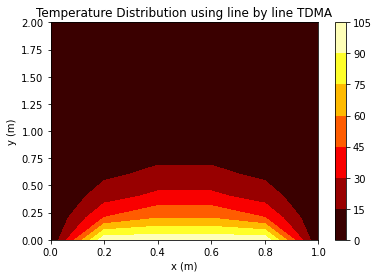

Text(0.5, 1.0, 'Error graph')

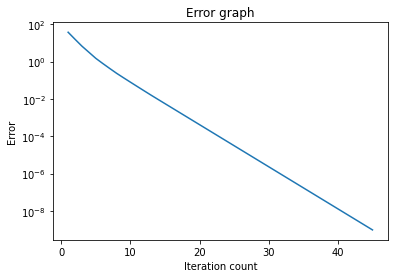

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
#Now we will start defining the TDMA function
def tdma(num, dia, upp, low, uPrev, u):
    P    = np.zeros(num)
    Q    = np.zeros(num)

    # Forward elimination
    P[0] = -upp[0]/dia[0]
    Q[0] =  uPrev[0]/dia[0]
    for i in range(1, len(dia)):
        P[i] = -(upp[i]/(dia[i]+low[i]*P[i-1]))
        Q[i] =  (uPrev[i] - low[i]*Q[i-1])/(dia[i]+low[i]*P[i-1])

    # Backward Substitution
    u[-1] = Q[-1]
    for i in range(len(dia)-2,-1,-1):
        u[i] = P[i]*u[i+1]+Q[i]
    return u

#Now we will start initializing the conditions
lx = 1
ly = 2
dx = 0.05
dy = 0.05
H = 2
L = 1
tol     = 0.000000001         # tolerance to stop  iterations
error=[]
no_mesh_x = int(lx/dx +1)
no_mesh_y = int(ly/dy +1)
Pos = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
#print(Pos)
T1= 100
x=0
y=0
T_old =np.zeros((no_mesh_y,no_mesh_x))
T_new = np.zeros((no_mesh_y,no_mesh_x))
for i in range(no_mesh_y):
  y=i*dy
  for j in range(no_mesh_x):
    x=j*dx
    Pos[i][j]=(x,y)
  x=0

T_guess = np.zeros((no_mesh_y,no_mesh_x))
T_guess[0:-1,0:-1] = 0
error=[]
for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

err = np.zeros((no_mesh_y,no_mesh_x))

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_old[i][j]= T_guess[i][j]

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_new[i][j]= T_guess[i][j]
#Applying TDMA in y direction sweep direction in x

converged = False

while (converged<=False):

  for j in range(1,no_mesh_x-1):
    T_new_free=np.zeros(no_mesh_y)
      # Diagonal elements of system matrix
    d    = np.zeros(no_mesh_y)        # main diagonal elements
    u    = np.zeros(no_mesh_y)        # upper diagonal
    l    = np.zeros(no_mesh_y)        # lower diagonal
    RHS  = np.zeros(no_mesh_y)
    d[0] = 1
    u[0] = 0
    l[0] = 0
    RHS[0]=T_new[0][j]
    d[-1] = 1
    u[-1] = 0
    l[-1] = 0
    RHS[-1]=T_new[-1][j]
    for i in range(1,no_mesh_y-1):
      d[i] = 4
      u[i] = -1
      l[i] = -1
      RHS[i]=T_new[i][j-1]+T_new[i][j+1]
    T_new_free = tdma(no_mesh_y, d, u, l, RHS, T_new_free)
    for i in range(0,no_mesh_y):
      T_new[i][j]=T_new_free[i]

  for i in range(0,no_mesh_y):
    for j in range(0,no_mesh_x):
      err[i][j]= abs(T_new[i][j] - T_old[i][j]) # absolute error calculation

  error.append(np.max(err))
  if (np.max(err) < tol): #setting up the convergence criterion
    converged = True

  for i in range(no_mesh_y):
    for j in range(no_mesh_x):
      T_old[i][j]= T_new[i][j]
#print(T_new)
iter = np.array(np.arange(1,len(error)+1,1))
iter=np.array(iter)
print(iter)
error=np.array(error)
T_new = np.array(T_new)
x = np.array(np.arange(0, L+dx, dx))
y = np.array(np.arange(0, H+dy, dy))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, T_new, cmap='hot')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution using line by line TDMA')
plt.show()
plt.plot(iter,error)
plt.xlabel('Iteration count')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error graph')

TDMA LINE BY LINE (#Applying TDMA in x direction sweep direction in y)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

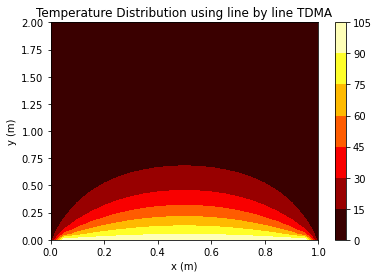

Text(0.5, 1.0, 'Error graph')

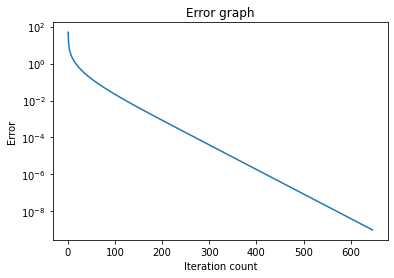

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt
#Now we will start defining the TDMA function
def tdma(num, dia, upp, low, uPrev, u):
    P    = np.zeros(num)
    Q    = np.zeros(num)

    # Forward elimination
    P[0] = -upp[0]/dia[0]
    Q[0] =  uPrev[0]/dia[0]
    for i in range(1, len(dia)):
        P[i] = -(upp[i]/(dia[i]+low[i]*P[i-1]))
        Q[i] =  (uPrev[i] - low[i]*Q[i-1])/(dia[i]+low[i]*P[i-1])

    # Backward Substitution
    u[-1] = Q[-1]
    for i in range(len(dia)-2,-1,-1):
        u[i] = P[i]*u[i+1]+Q[i]
    return u

#Now we will start initializing the conditions
lx = 1
ly = 2
dx = 0.05
dy = 0.05
H = 2
L = 1
tol     = 0.000000001         # tolerance to stop  iterations
error=[]
no_mesh_x = int(lx/dx +1)
no_mesh_y = int(ly/dy +1)
Pos = [[None for j in range(no_mesh_x)] for i in range(no_mesh_y)]
#print(Pos)
T1= 100
x=0
y=0
T_old =np.zeros((no_mesh_y,no_mesh_x))
T_new = np.zeros((no_mesh_y,no_mesh_x))
for i in range(no_mesh_y):
  y=i*dy
  for j in range(no_mesh_x):
    x=j*dx
    Pos[i][j]=(x,y)
  x=0

T_guess = np.zeros((no_mesh_y,no_mesh_x))
T_guess[0:-1,0:-1] = 0
error=[]
for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

for i in range(1,no_mesh_x-1):
  T_guess[0,i] = 100

err = np.zeros((no_mesh_y,no_mesh_x))

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_old[i][j]= T_guess[i][j]

for i in range(no_mesh_y):
  for j in range(no_mesh_x):
    T_new[i][j]= T_guess[i][j]
#Applying TDMA in y direction sweep direction in x

converged = False

while (converged<=False):

  for j in range(1,no_mesh_y-1):
    T_new_free=np.zeros(no_mesh_x)
      # Diagonal elements of system matrix
    d    = np.zeros(no_mesh_x)        # main diagonal elements
    u    = np.zeros(no_mesh_x)        # upper diagonal
    l    = np.zeros(no_mesh_x)        # lower diagonal
    RHS  = np.zeros(no_mesh_x)
    d[0] = 1
    u[0] = 0
    l[0] = 0
    RHS[0]=T_new[j][0]
    d[-1] = 1
    u[-1] = 0
    l[-1] = 0
    RHS[-1]=T_new[j][-1]
    for i in range(1,no_mesh_x-1):
      d[i] = 4
      u[i] = -1
      l[i] = -1
      RHS[i]=T_new[j-1][i]+T_new[j+1][i]
    T_new_free = tdma(no_mesh_x, d, u, l, RHS, T_new_free)
    for i in range(0,no_mesh_x):
      T_new[j][i]=T_new_free[i]

  for i in range(0,no_mesh_y):
    for j in range(0,no_mesh_x):
      err[i][j]= abs(T_new[i][j] - T_old[i][j]) # absolute error calculation

  error.append(np.max(err))
  if (np.max(err) < tol): #setting up the convergence criterion
    converged = True

  for i in range(no_mesh_y):
    for j in range(no_mesh_x):
      T_old[i][j]= T_new[i][j]
#print(T_new)
iter = np.array(np.arange(1,len(error)+1,1))
iter=np.array(iter)
print(iter)
error=np.array(error)
T_new = np.array(T_new)
x = np.array(np.arange(0, L+dx, dx))
y = np.array(np.arange(0, H+dy, dy))
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, T_new, cmap='hot')
plt.colorbar()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Temperature Distribution using line by line TDMA')
plt.show()
plt.plot(iter,error)
plt.xlabel('Iteration count')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Error graph')

ERROR NEED TO RUN CODE BEFORE IN COLAB

In [ ]:
err = np.zeros((no_mesh_y,no_mesh_x))

for i in range(0,no_mesh_y):
  for j in range(0,no_mesh_x):
    err[i][j]= abs(T_new[i][j] - Tx[i][j])

error = 0
for i in range(0,no_mesh_y):
  for j in range(0,no_mesh_x):
    error = error+ (err[i][j])**2
print(error/(no_mesh_x+no_mesh_y))

0.4923317784671906


Question 1 A EXPLICIT METHOD

Streaming output truncated to the last 5000 lines.
0.00011066714790786136
0.00011056298546918697
0.0001104589216538443
0.00011035495504074788
0.00011025108705098319
0.00011014731626346475
0.00011004364353084384
0.00010994006771625209
0.00010983658967234078
0.00010973320939910991
0.00010962992661234239
0.00010952674045938693
0.00010942365150867772
0.00010932066004443186
0.00010921776492978097
0.00010911496673315924
0.00010901226545456666
0.00010890966080978615
0.00010880715308303479
0.00010870474142166131
0.0001086024261098828
0.00010850020714769926
0.00010839808453511068
0.00010829605827211708
0.00010819412722185007
0.00010809229280539512
0.00010799055445431804
0.00010788891131596756
0.00010778736367456077
0.00010768591266696603
0.0001075845563036637
0.00010748329543730506
0.00010738212949945591
0.00010728105934276755
0.00010718008439880577
0.0001070792043833535
0.00010697841929641072
0.00010687772885376035
0.00010677713305540237
0.0001066766321855539
0.00010657622595999783
0.000106475

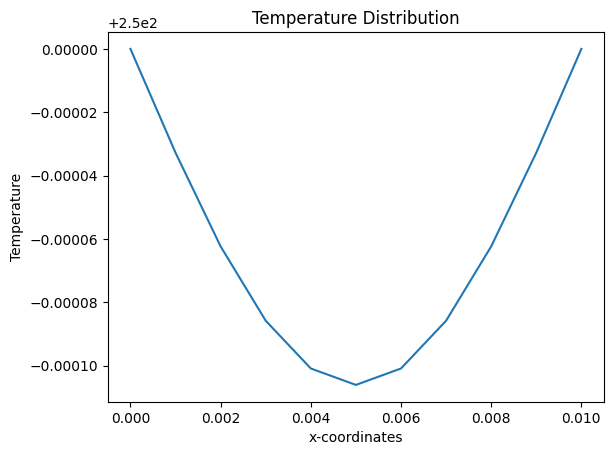

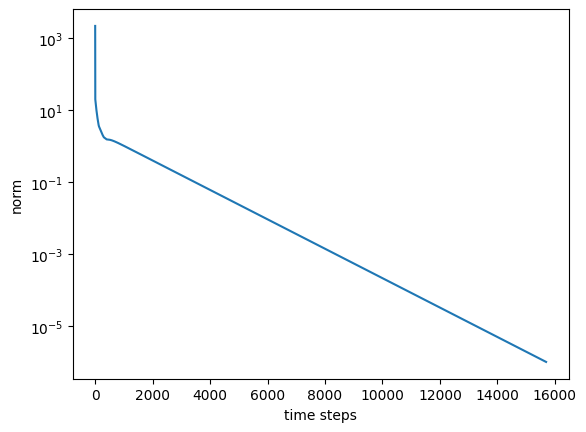

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
#print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30

# Solve the discretized equation until steady state is achieved
norm_collect = []         # To collect the norm
sub_list = list([])       # Making a list to store the difference between the two arrays
norm        = 100.0       # Measure of residual or error
iter        = 0           # Iteration counter
converged   = False       # Convergence flag - changes to "True" upon convergence

while (converged==False):
  t = t + dt

  for i in range(1,(len(T_old)-1)):
    T_new[i] = C*T_old[i-1] + (1-2*C)*T_old[i] + C*T_old[i+1]

  T_new = applybc(T_new)

  sub_list = list([])

  # Increment iteration counter
  iter = iter + 1

  for i1,i2 in zip(T_new,T_old):
    sub_list.append(abs(i1-i2))

  norm = max(sub_list)/dt

  norm_collect.append(norm)

  if norm <10**-6:
    converged = True

  #print(T_new)
  for i in range(0,len(T_new)):
    T_old[i] = T_new[i]
  print(norm)

plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
plt.show()

tsteps = np.linspace(1,iter,iter)
norm_collect = np.array(norm_collect)
plt.plot(tsteps,norm_collect)
plt.yscale('log')
plt.xlabel("time steps")
plt.ylabel("norm")
plt.show()


Question 1 A EXPLICIT METHOD DYNAMIC MODE DECOMPOSITION

Streaming output truncated to the last 5000 lines.
0.00011073248089132903
0.00011062825677754518
0.00011052413128709304
0.00011042010385153844
0.00011031617390244719
0.00011021234229247057
0.0001101086078847402
0.00011000497124769026
0.00010990143266553787
0.00010979799100141463
0.00010969464710797183
0.0001095913998483411
0.00010948825007517371
0.00010938519778846967
0.00010928224213557769
0.00010917938311649777
0.00010907662129966411
0.0001089739564008596
0.00010887138756743298
0.0001087689156520355
0.000108666540086233
0.00010856426058580837
0.0001084620777191958
0.00010835999120217821
0.0001082580001821043
0.00010815610551162536
0.00010805430690652429
0.00010795260379836691
0.00010785099647137031
0.00010774948520975158
0.00010764806887664236
0.000107546748608911
0.00010744552298547205
0.00010734439342741098
0.00010724335822942521
0.00010714241881260023
0.00010704157432428474
0.00010694082419604456
0.00010684016956474807
0.00010673960929352688
0.0001066391436665981
0.000106538772683

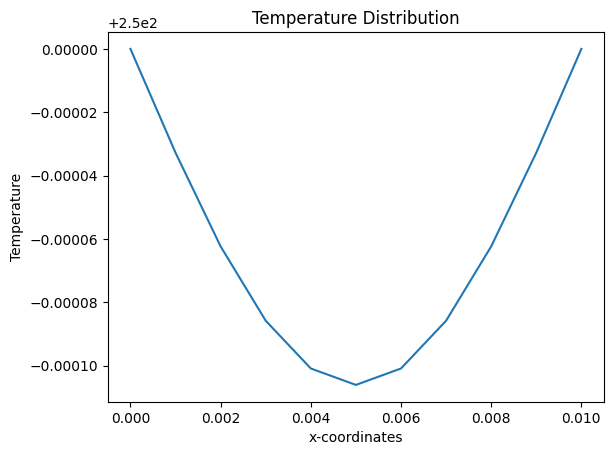

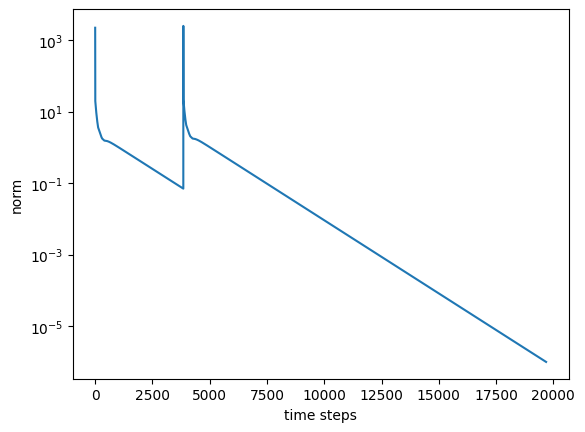

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Now we will integrate the Dynamic Mode Decomposition
#Now we will define a function named DMDsolver which will split up our given matrix X into two matrices X1 and X2
def DMDsolver(X_given,r,no_predictions,dt):
  X1 = X_given[:, : -1] #splitting our given matrix into two matrices X1 and X2
  X2 = X_given[:, 1 :]
  #R, C = X.shape #R,C rows and columns no , shape function performs the task of finding no of rows and columns
  U, E, Vt = np.linalg.svd(X1, full_matrices = False) #Applying SVD on X1 as a first step of DMD algorithm
  """In the next step we obtain the matrix A_bar which is an second and important step in DMD algo, this matrix is obtained by multiplication
  of the truncated  matrices"""
  A_bar = np.matmul((np.matmul(np.matmul(U[:, : r].conj().T,X2),Vt[: r, :].conj().T)),np.diag(np.reciprocal(E[: r])))
  '''In the following step we obtain the eigen decomposition of the matrix A_bar into two matrices Phi and Q representing eigen values
  and eigen vectors matrices respectively'''
  Phi, Q = np.linalg.eig(A_bar)
  '''The following step we find Psi matrix in order to find A matrix '''
  Psi=np.matmul(np.matmul(np.matmul(X2,Vt[: r, :].conj().T),np.diag(np.reciprocal(E[: r]))),Q) #dmd mode
  #Here we go to the final step of finding our matrix A which is the root of DMD prediction
  A=np.matmul(np.matmul(Psi,np.diag(Phi)),np.linalg.pinv(Psi)) #not needed from this line for finite differences
  x2 = X2[:,-1]
  #print(Psi)
  bi = (np.matmul(np.linalg.pinv(Psi),x2))
  dd1 = ((bi[0])*(Psi[:,0])).real
  dd2 = ((bi[1])*(Psi[:,1])).real
  dd3 = ((bi[2])*(Psi[:,2])).real
  dd4 = ((bi[3])*(Psi[:,3])).real
  dd5 = np.zeros(len(dd1))
  for i in range(len(dd1)):
   dd5[i] = dd1[i] + dd2[i] + dd3[i] +dd4[i]
  return dd5 #returning predicted values matrix

k = 0.25
Co = 2000
density = 1300
alpha = k / (Co*density)
dx = 0.001 #taking everything in the SI units system
X = np.array(np.arange(0,0.01+dx,dx))
dt = float(input("ENTER THE TIME STEP: "))
t = 0
#print(X)
C = alpha*dt/(dx)**2

T_old = np.zeros(len(X))
T_new = np.zeros(len(X))

def applybc(T):
  T[0] = 250
  T[-1]= 250
  return T

T_old[:] = 30
ic=1
# Solve the discretized equation until steady state is achieved
norm_collect = []         # To collect the norm
sub_list = list([])       # Making a list to store the difference between the two arrays
norm        = 100.0       # Measure of residual or error
iter        = 0           # Iteration counter
converged   = False       # Convergence flag - changes to "True" upon convergence
Y=list([])
lo = 1
PPP=0

while (converged==False):

  if ((norm>0.1) and (PPP<=1)):
    t = t + dt

    for i in range(1,(len(T_old)-1)):
      T_new[i] = C*T_old[i-1] + (1-2*C)*T_old[i] + C*T_old[i+1]

    T_new = applybc(T_new)

    sub_list = list([])

    for i1,i2 in zip(T_new,T_old):
      sub_list.append(abs(i1-i2))

    norm = max(sub_list)/dt

    norm_collect.append(norm)

    if norm <10**-6:
      converged = True

    #print(T_new)

    for i in range(0,len(T_new)):
      T_old[i] = T_new[i]
    print(norm)
    iter = iter + 1
    nu = iter
    ic = iter
  else:
    #print(u_old,903480935874)
    PPP = 5
    if (norm<=10**-6):
      converged = True
    if ((iter==nu) and (lo<=20) and (iter==ic)):
      Y.append(T_old)
      nu=nu+20
      ic=ic+20
      if (lo==20):
        print(1111111111123456789999999999999998765)
        Y = np.array(Y)
        Y = Y.transpose()
        T_old = DMDsolver(Y,5,1,dt)
        ic = ic + 1111200
        nu = iter
        Y=list([])
        #print(nu,ic,iter)
        lo = 0
      lo=lo+1

    t = t + dt

    for i in range(1,(len(T_old)-1)):
      T_new[i] = C*T_old[i-1] + (1-2*C)*T_old[i] + C*T_old[i+1]

    T_new = applybc(T_new)

    sub_list = list([])

    # Increment iteration counter
    iter = iter + 1

    for i1,i2 in zip(T_new,T_old):
      sub_list.append(abs(i1-i2))

    norm = max(sub_list)/dt

    norm_collect.append(norm)

    if norm <10**-6:
      converged = True

    #print(T_new)

    for i in range(0,len(T_new)):
      T_old[i] = T_new[i]

    if (iter == ic):
      nu =iter
    print(norm)

plt.plot(X,T_new)
plt.xlabel("x-coordinates")
plt.ylabel("Temperature")
plt.title("Temperature Distribution")
plt.show()

tsteps = np.linspace(1,iter,iter)
norm_collect = np.array(norm_collect)
plt.plot(tsteps,norm_collect)
plt.yscale('log')
plt.xlabel("time steps")
plt.ylabel("norm")
plt.show()
